In [12]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import itertools
from collections import OrderedDict
from tqdm import tqdm_notebook, tqdm
from scipy import stats

import os

%matplotlib inline

# Load AllMusic Graph

In [3]:
# Load artist information
artists = pd.read_csv('data/allmusic/artists_cleaned.csv')
# Load influence relationships
influences = pd.read_csv('data/allmusic/influences_cleaned.csv')

In [15]:
# Create directed graph from influence relationships
allmusic = nx.DiGraph()

for row in influences.itertuples():
    allmusic.add_edge(row.influencer_name, row.follower_name)

# Load MusicBrainz Collaborators

In [5]:
# Load collaboration data from MusicBrainz
mb = nx.read_gexf('data/musicbrainz/sdn-unweighted.gexf')

In [6]:
# Summary of collaboration graph
print nx.info(mb)

Name: 
Type: Graph
Number of nodes: 271442
Number of edges: 650920
Average degree:   4.7960


In [7]:
print nx.number_connected_components(mb)

26654


# Compute Edge Overlap Between AllMusic Graph and MusicBrainz Collaboration Graph

In [8]:
allmusic_edges = set(allmusic.edges())
# Define the reverse order of each edge tuple to be an influence relationship as well
# since the mb graph is undirected
mb_edges = set(mb.edges() + [(edge[1], edge[0]) for edge in mb.edges()])

In [9]:
print "Number of edges in intersection:", len(allmusic_edges.intersection(mb_edges))
print "Percentage of AllMusic edges covered:", len(allmusic_edges.intersection(mb_edges)) / float(len(allmusic_edges))

Number of edges in intersection: 3093
Percentage of AllMusic edges covered: 0.0332459100974


# Compute Node Overlap

In [10]:
allmusic_nodes = set(allmusic.nodes())
mb_nodes = set(mb.nodes())

print "Number of nodes in intersection:", len(allmusic_nodes.intersection(mb_nodes))
print "Percentage of AllMusic nodes covered:", len(allmusic_nodes.intersection(mb_nodes)) / float(len(allmusic_nodes))

Number of nodes in intersection: 10214
Percentage of AllMusic nodes covered: 0.615560778642


# Compute Edge Overlap For Subset of Nodes Contained within Node Overlap

In [11]:
intersection_nodes = allmusic_nodes.intersection(mb_nodes)
# Filter for edges where both nodes are contained within the node intersection of the two datasets
allmusic_edges_filtered = set([edge for edge in allmusic.edges() if edge[0] in intersection_nodes and edge[1] in intersection_nodes])
print "Percentage of filtered AllMusic edges covered:", len(allmusic_edges.intersection(mb_edges)) / float(len(allmusic_edges_filtered))

Percentage of filtered AllMusic edges covered: 0.0513309877854


# Compute Node/Edge Overlap Between Audio Dataset and Influence Graph

In [32]:
# Load list of artist ids that we have audio for
ids_with_audio_raw = open('data/artists_with_audio.txt', 'r').readlines()
# Apply mild cleaning to isolate id strings
ids_with_audio = map(lambda x: int(x.split('PRE ')[-1].strip('/\n')), ids_with_audio_raw)

In [34]:
# Compute id overlap between 2 lists
print "Number with audio:", len(ids_with_audio)
print "Number ids total:", len(np.unique(artists['id']))
print "Percentage node overlap:", len(ids_with_audio) / float(len(np.unique(artists['id'])))

Number with audio: 15460
Number ids total: 16704
Percentage node overlap: 0.925526819923


In [35]:
# Load influence relationships
influences = pd.read_csv('data/allmusic/influences_cleaned.csv')

# Create full directed graph from influence relationships
full_influence_graph = nx.DiGraph()

for row in influences.itertuples():
    full_influence_graph.add_edge(row.influencer_id, row.follower_id)

In [36]:
# Create subgraph based on nodes we have audio for
audio_subgraph = full_influence_graph.subgraph(ids_with_audio)

In [37]:
print "Number of edges in subgraph:", audio_subgraph.number_of_edges()
print "Number of edges in full graph:", full_influence_graph.number_of_edges()
print "Percentage edge overlap:", audio_subgraph.number_of_edges() / float(full_influence_graph.number_of_edges())

Number of edges in subgraph: 89007
Number of edges in full graph: 93065
Percentage edge overlap: 0.956396067265


# Compute Distribution of Number of Audio Samples Per Artist

In [4]:
AUDIO_BASE_DIR = '/Volumes/thesis/audio/'

number_of_samples = []

for artist_id in os.listdir(AUDIO_BASE_DIR):
    number_of_samples.append(len(os.listdir(AUDIO_BASE_DIR + artist_id)))

count    15460.000000
mean         9.290103
std          2.081990
min          1.000000
25%         10.000000
50%         10.000000
75%         10.000000
max         10.000000
dtype: float64

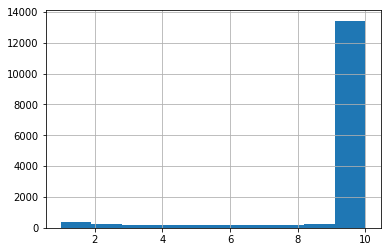

In [22]:
# Convert to pandas Series
number_of_samples = pd.Series(number_of_samples)
number_of_samples.hist()
number_of_samples.describe()

In [28]:
len(number_of_samples[number_of_samples < 5]) / float(len(number_of_samples))

0.06720569210866753

In [29]:
sum(number_of_samples)

143625